In [1]:
from _py.config import config
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
from matplotlib.colors import LinearSegmentedColormap 
from sklearn.metrics import auc, roc_curve
import matplotlib.patheffects as pe

from scipy.stats import probplot
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_sql('SELECT*FROM train', config.engine, index_col='id')
test = pd.read_sql('SELECT*FROM test', config.engine, index_col='id')

target = train[config.target_name]
train = train.drop(config.target_name, axis=1)

In [3]:
BASE_ALL_FEATURES = train.columns.to_list()
BASE_CAT_FEATURES = train.select_dtypes(include=['object', 'category']).columns.to_list()
BASE_NUM_FEATURES = train.select_dtypes(include='number').columns.to_list()

In [4]:
orig = pd.read_sql(f'SELECT * FROM orig', config.engine)[BASE_ALL_FEATURES+[target.name]]
orig_target = orig[target.name]
orig = orig.drop(target.name, axis=1)

In [5]:
GRUVBOX_COLORS = ["#c21161", "#ffec44"]

RC = {
    "figure.facecolor": "#1e222d", # задний фон фигуры
    "axes.facecolor": "#171b26", # фон графиков
    "grid.color": "#b4c2be", # цвет сетки
    "grid.alpha": 0.25, # прозрачность сетки
    "axes.edgecolor": "#e0e0e0", # Рамка
    "axes.linewidth": 0.8, # толщина рамки
    "legend.facecolor": "#323740", # цвет легенды
    "legend.labelcolor" : "ffffff", # Цвет текста на легендах
    "axes.titlecolor": "#ffffff", # Цвет текста в заголовке 
    "axes.labelcolor": "#ffffff", # мини заголовки осей
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    "xtick.color": "#ffffff",
    "ytick.color": "#ffffff",
    "axes.prop_cycle": cycler(color=GRUVBOX_COLORS),
}
sns.set(rc=RC, style="darkgrid")

In [19]:
def plot_pieplot(data, cat_cols=None):
    data_ = pd.DataFrame(data).copy()
    cat_cols = cat_cols or data_.columns.to_list()
    length = len(cat_cols)

    fig, axes = plt.subplots(
            nrows=length,
            ncols=2,
            figsize=(18, length*6),
            gridspec_kw={
                'height_ratios': [1] * length,
                'wspace': 0.01,
                'hspace': 0.2,
                'width_ratios': [0.5, 0.5] },
        )
    axes = np.atleast_2d(axes)
    for i, col in enumerate(cat_cols):
        vc = data_[col].value_counts()
        labels = vc.index.tolist()
        sizes = vc.values
        cmap = LinearSegmentedColormap.from_list("my_cmap", ['#ffec44', '#ffffff', '#c21161'])
        colors_list = [cmap(x) for x in np.linspace(0, 1, len(labels))]
        palette_dict = {cat: colors_list[idx] for idx, cat in enumerate(labels)}
        # pie
        ax = axes[i, 0]
        ax.pie(sizes,
               labels=labels,
               startangle=90, frame=True, radius=1,
               wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
               textprops={'fontsize': 11, 'weight':'bold', 'color': 'white',
                         'path_effects': [pe.Stroke(linewidth=0.9, foreground='black'), 
                                          pe.Normal()]},
               autopct='%1.1f%%',
               labeldistance=1.05,
               colors=[palette_dict[c] for c in labels])
        ax.set_title(col, size=14, color='white', fontweight='bold', path_effects=[pe.Stroke(linewidth=0.9, foreground='black'),
                                                                                   pe.Normal()])
        ax.set_xlim(-1.25, 1.25)
        ax.set_ylim(-1.25, 1.25)
        
        ax.grid(True)
        # countplot
        ax = axes[i, 1]
        sns.countplot(
            data=data_,
            x=col,
            order=labels,
            hue=col,
            legend=True,
            ax=ax,
            palette=palette_dict
        )
        for container in ax.containers:
            ax.bar_label(container,
                         color='white', 
                         fontsize=12,
                         weight='bold',
                         path_effects=[pe.Stroke(linewidth=0.9, foreground='black'),
                                       pe.Normal()])
        ax.set_title(col, size=14, color='white', fontweight='bold',
                    path_effects=[pe.Stroke(linewidth=0.9, foreground='black'),
                                  pe.Normal()])
        ax.set_xlabel('')
        leg = ax.get_legend()
        leg.get_title().set_color("white")
        leg.set_loc("upper right")
        
    plt.show()

In [25]:
def plot_num(data, num_cols=None, target=None):
    
    num_cols = num_cols or data.select_dtypes(include='number').columns.to_list()
    length = len(num_cols)
    fig, axes = plt.subplots(
        nrows=length,
        ncols=3,
        figsize=(20, length*5),
        gridspec_kw={
            'height_ratios': [1] * length,
            'wspace': 0.1,
            'hspace': 0.1,
            'width_ratios': [0.5, 0.25, 0.25] },
        constrained_layout=True
    )
    axes = np.atleast_2d(axes)
    for i, col in enumerate(num_cols):
        
        # hist-plot
        ax = axes[i, 0]
        sns.histplot(x=col, hue=target, data=data, kde=True, ax=ax)
        leg = ax.get_legend()
        if leg is not None:
            leg.set_title(target.name, prop={'size': 16}) 
            for text in leg.get_texts():
                text.set_fontsize(16) 
                
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(col, size=18)
        
        leg = ax.get_legend()
        leg.get_title().set_color("white")
        leg.set_loc("upper right")
        # boxplot
        ax = axes[i, 1]
        sns.boxplot(data=data, y=col, width=0.5, ax=ax,
                    flierprops=dict(markerfacecolor='#d6fffb', marker='o', markersize=6),
                    whiskerprops=dict(color='#d6fffb'),
                    capprops=dict(color='#d6fffb'),
                    medianprops=dict(color='#d6fffb'),
                    boxprops=dict(edgecolor='#d6fffb', linewidth=1),)
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(col, size=18)
        
        # QQ-plot
        ax = axes[i, 2]
        probplot(data[col], plot=ax)
        ax.get_lines()[0].set_color('#68acd4')
        ax.get_lines()[1].set_color('#b81223')
        
        ax.set_xlabel('Theoretical quantiles', size=15)
        ax.set_ylabel('Ordered values', size=15)
        ax.set_title(col, size=18)
        

    plt.show()

In [11]:
def plot_heatmap(data, target=None, cat=False, method='pearson', figsize=(14, 10)):
    cmap = LinearSegmentedColormap.from_list("my_cmap", ['#ffec44', '#ffffff', '#c21161'])
    data_ = pd.DataFrame(data.copy())
    
    if target is not None:
        data_[target.name] = target
    if cat:
        cat_cols = data_.select_dtypes(include=['object', 'category']).columns.to_list()
        label_encoders = {}
        for col in cat_cols:
            le = LabelEncoder()
            data_[col] = le.fit_transform(data_[col].astype(str))
            label_encoders[col] = le

    num_features = data_.select_dtypes(exclude='object').columns.to_list()    
    corr = data_[num_features].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    np.fill_diagonal(mask, False)
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(data=corr, mask=mask, linewidths=0.5, fmt='0.2f',linecolor='#39403f', cmap=cmap, annot=True, annot_kws={"size": 10},
               alpha=1, center=0, vmin=-1, ax=ax)
    plt.grid(False)
    plt.show()

In [28]:
def plot_cat(data, target, cat_cols=None):
    cat_cols = cat_cols or data.select_dtypes(include=['object', 'category']).columns.to_list()

    plt.figure(figsize=(16, len(cat_cols)*3))
    for i, col in enumerate(cat_cols):
        
        plt.subplot(len(cat_cols)//2 + len(cat_cols) % 2, 2, i+1)
        ax = plt.gca()
        sns.countplot(x=col, hue=target, data=data)
        plt.title(f"{col} countplot by outcome", fontweight = 'bold', color='white')
        plt.ylim(0, data[col].value_counts().max() + 10)
        plt.xlabel('')
        for container in ax.containers:
            ax.bar_label(container,
                         color='white', 
                         fontsize=12,
                         weight='bold',
                         path_effects=[pe.Stroke(linewidth=0.9, foreground='black'),
                                       pe.Normal()])
        ax.set_title(col, size=13, color='white', fontweight='bold',
                    path_effects=[pe.Stroke(linewidth=0.9, foreground='black'),
                                  pe.Normal()])
        leg = ax.get_legend()
        leg.get_title().set_color("white")
        leg.set_loc("upper right")
        
    plt.tight_layout()
    plt.show()


In [13]:
def plot_pair(data, cols, hue):
    combs = list(combinations(cols, 2))
    LENGTH = len(combs)
    
    plt.figure(figsize=(25, len(combs)*2.5))
    for i, (x, y) in enumerate(combs):
        plt.subplot(LENGTH//3 + LENGTH % 3, 3, i+1)
        ax = plt.gca()
        
        sns.scatterplot(data=data, x=x, y=y, hue=hue)
        leg = ax.get_legend()
        leg.get_title().set_color("white")
        leg.set_loc("lower right")
        
        ax.set_title(f'"{x}" and "{y}"', size=18)
    plt.show()

-------

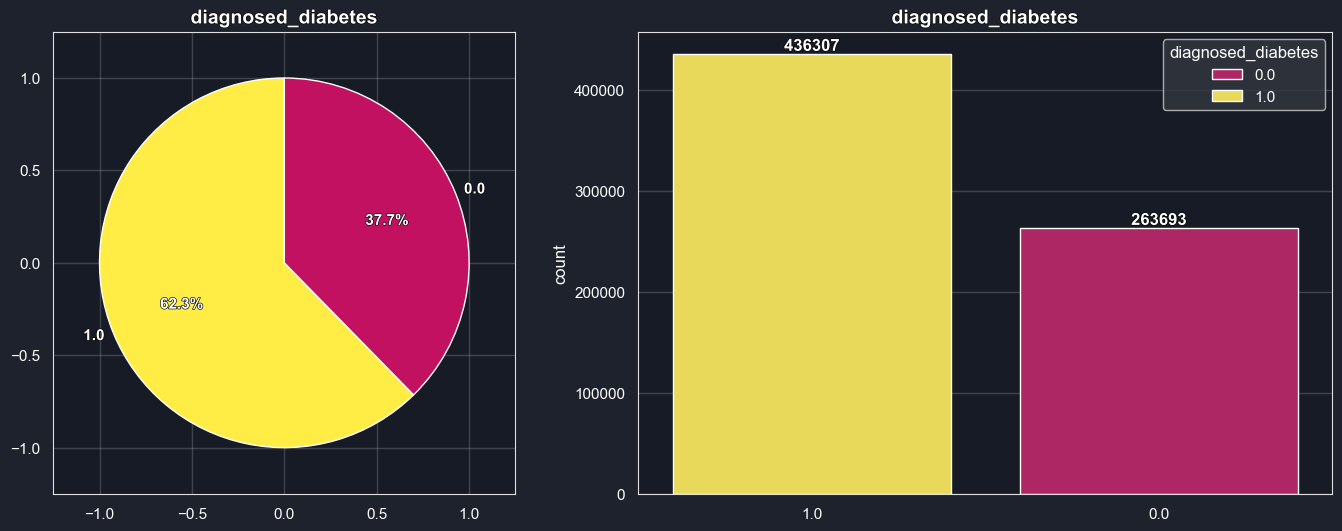

In [20]:
plot_pieplot(target)

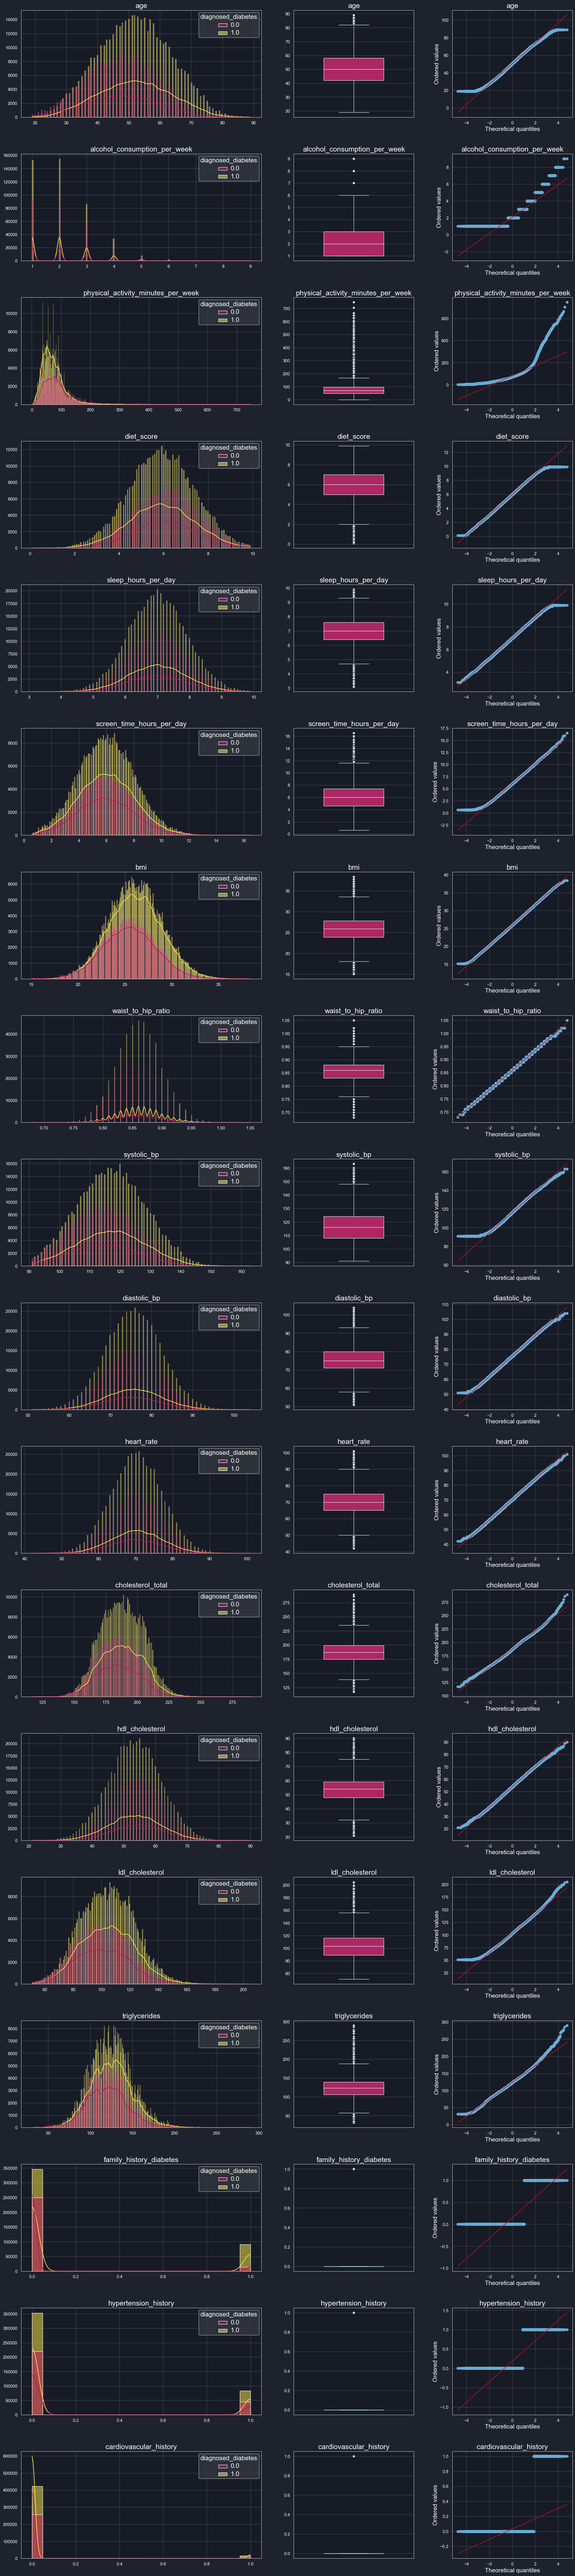

In [26]:
plot_num(train, target=target)

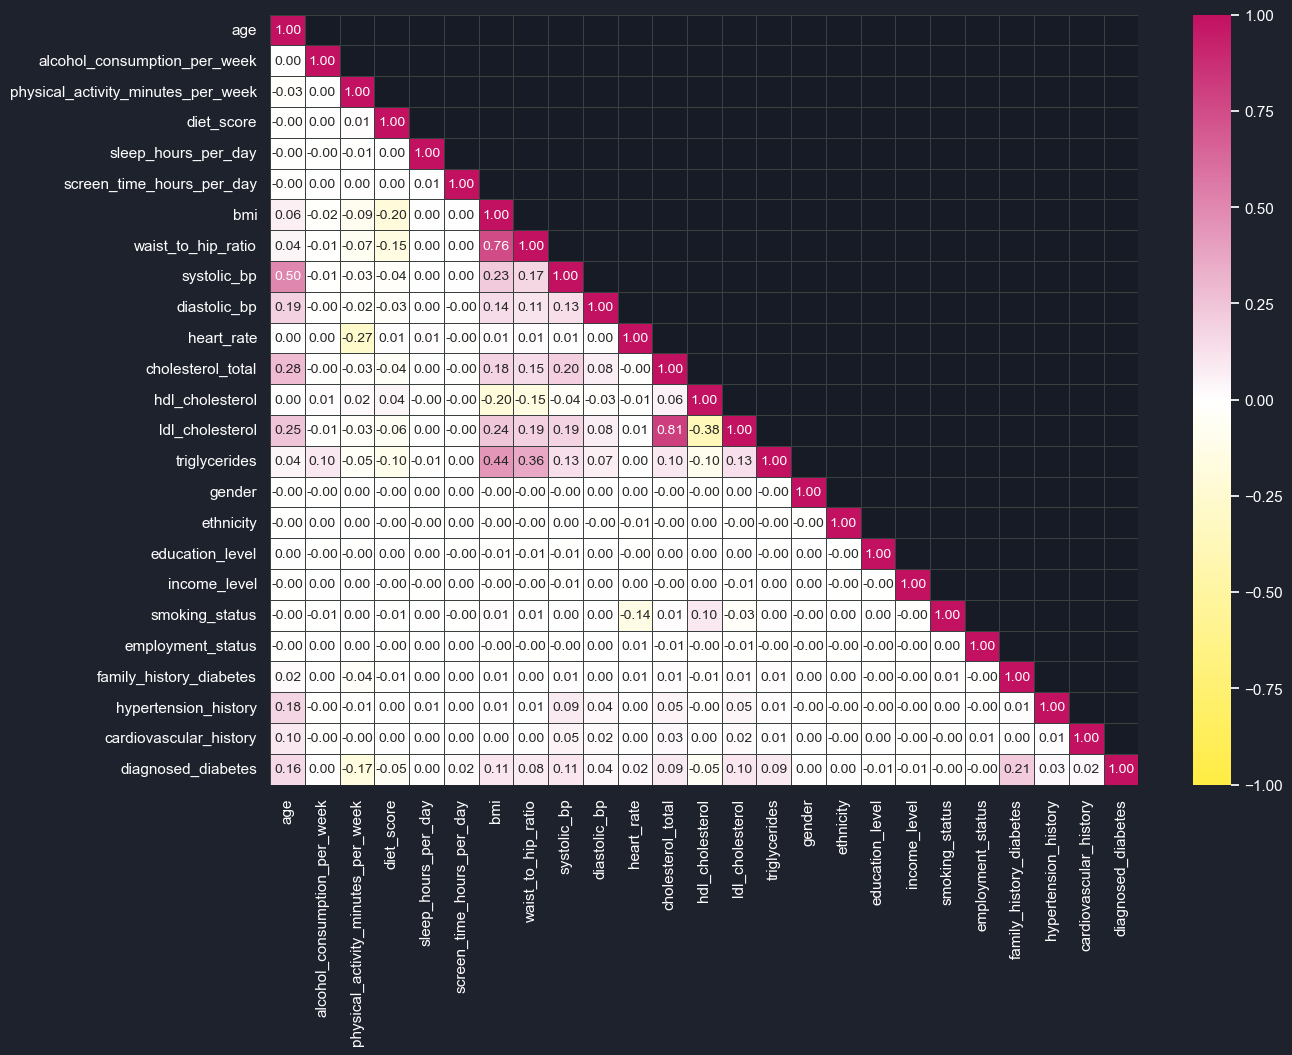

In [27]:
plot_heatmap(train, target, cat=True)

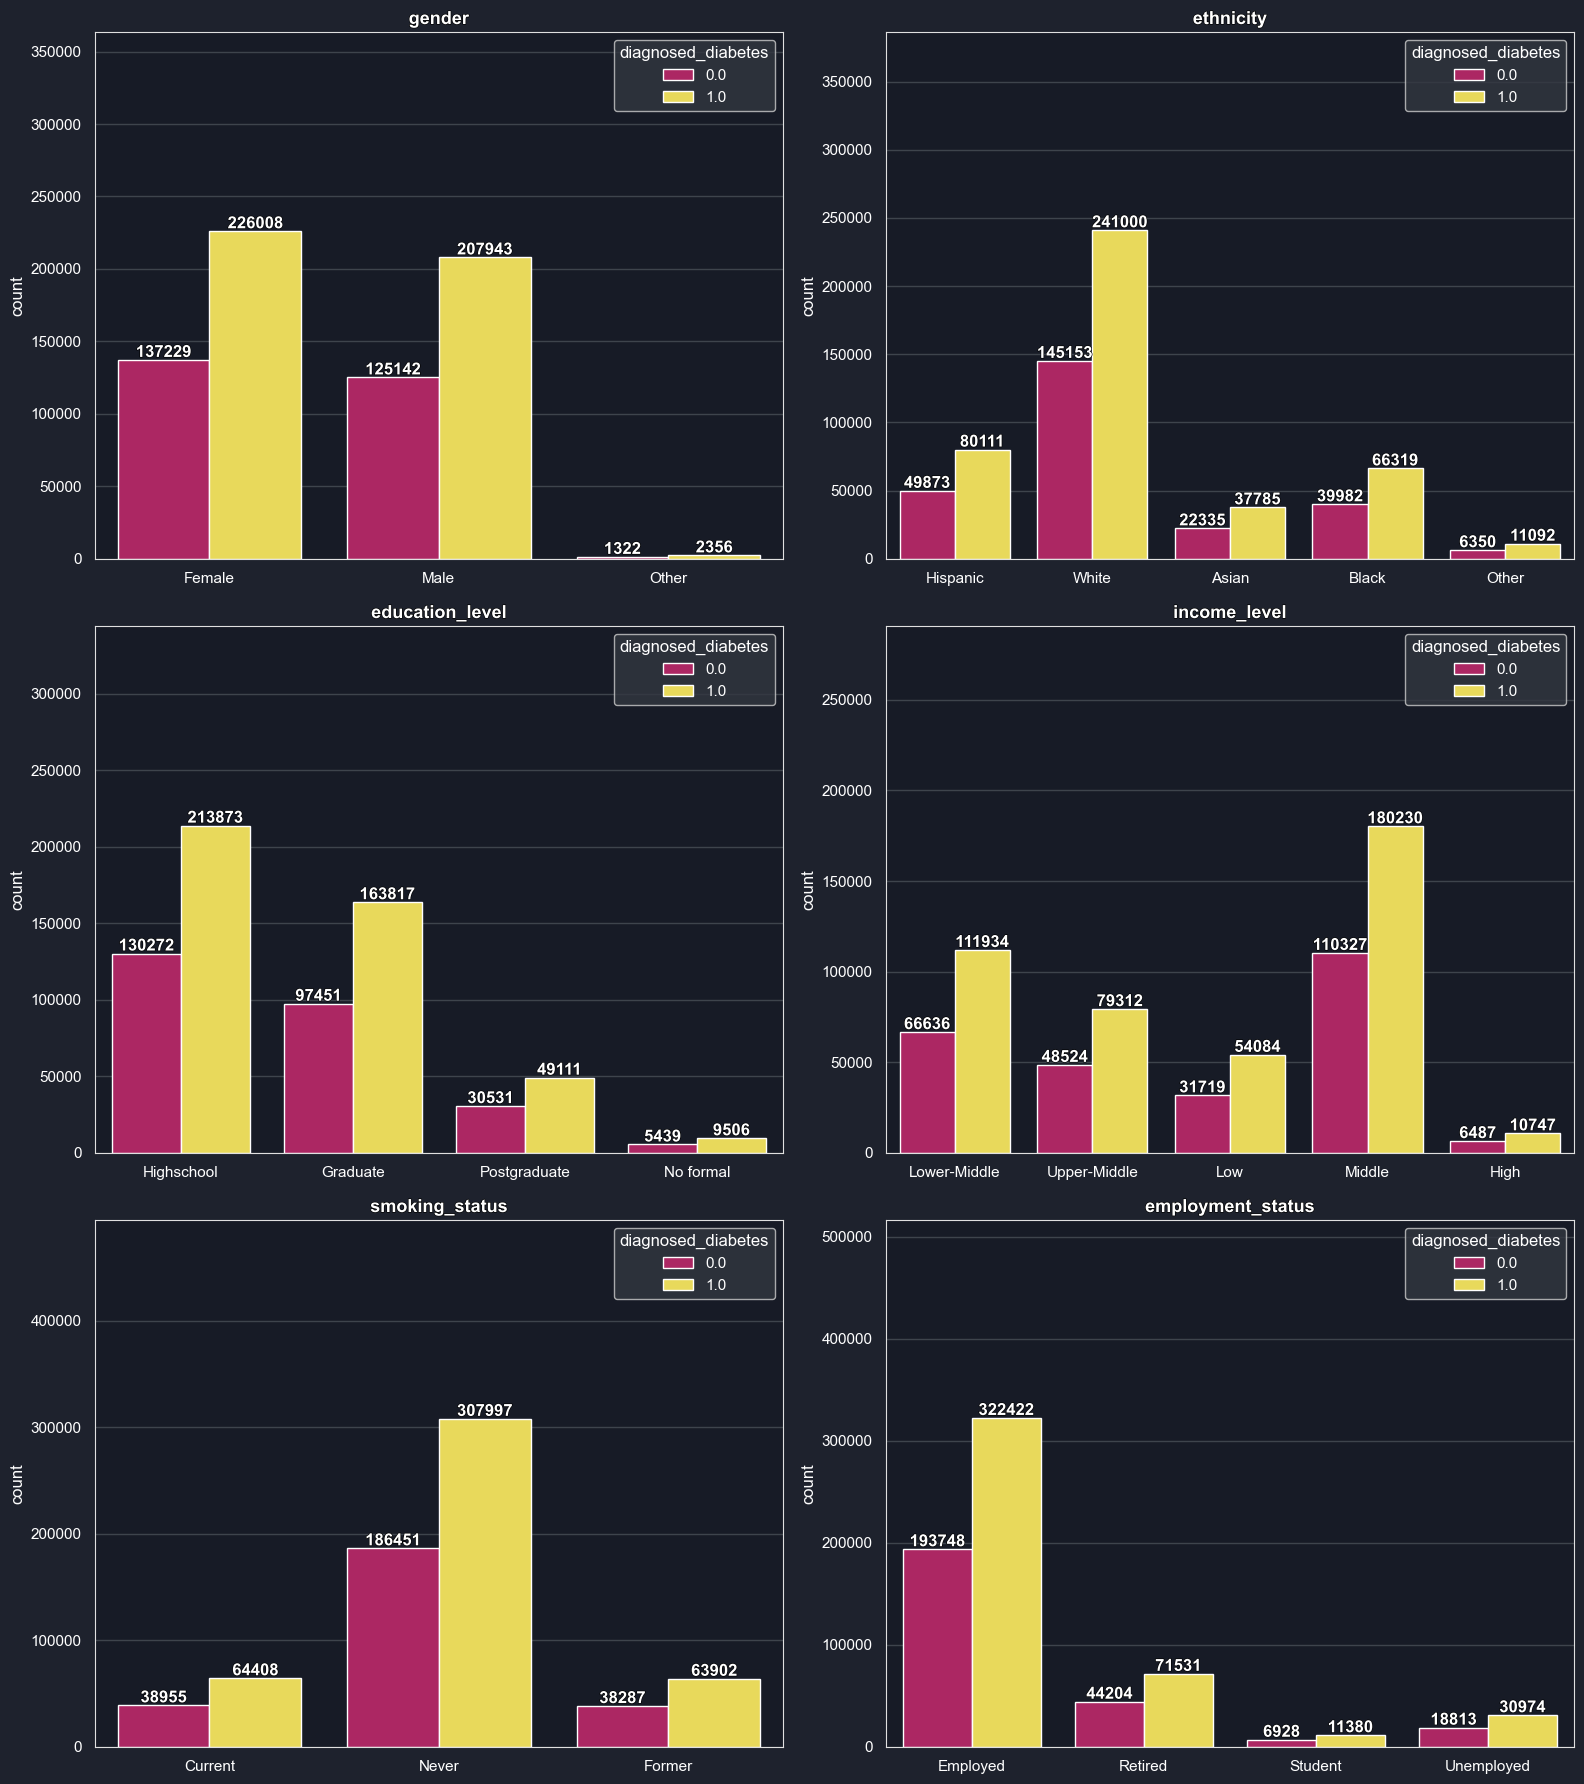

In [29]:
plot_cat(train, target)

-------

# Feature Importance